<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

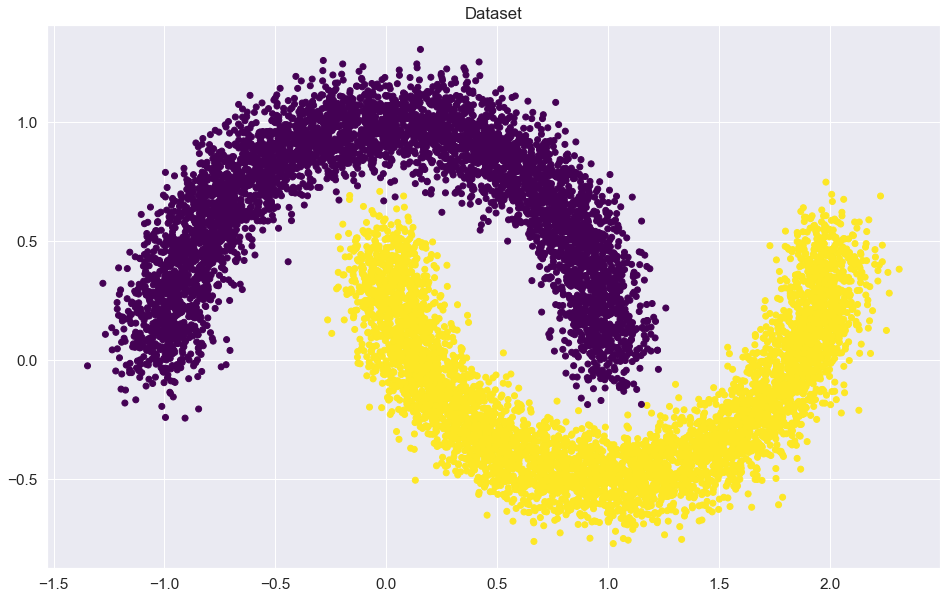

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
#получаем тензоры из нампай и приводим его к 32 битам, для экономии памяти
X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
#аналогично сделаем с валидацией
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к классу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((in_features, out_features), 
                                          requires_grad=True))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.ones(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

[Подробнее о функции summary](https://github.com/tyleryep/torchinfo)

In [9]:
!pip install torchinfo

In [10]:
from torchinfo import summary

summary(linear_regression, (1, 2))

C:\Users\user\anaconda3\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
C:\Users\user\anaconda3\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

Обучаемых параметров: 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

### Корректное решение на CPU

In [11]:
#Без этой строки не хочет корректно решать на CPU
#Это странно, ведь по умолчанию модель должна как раз быть на CPU
linear_regression = linear_regression.to('cpu')

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
#итерируемся по датасэту max_epochs раз
for epoch in range(max_epochs):
    #итерируемся по датасэту. Размер батча - 128, установили выше
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        #обнуляем градиенты, чтобы не накапливались
        optimizer.zero_grad()
        
        #получаем "логиты" из модели
        #outp.shape--->torch.Size([128,1])
        outp = linear_regression(X_batch)
        
        #outp.shape--->torch.Size([128])
        outp = outp.view(-1)
        
        #считаем loss
        loss = loss_function(outp, y_batch)
        #пример, как выглядит loss
        #tensor(0.8063, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
        
        #считаем градиенты
        loss.backward()
        
        losses.append(loss.detach().flatten()[0])
        
        #шаг градиентного спуска
        optimizer.step()
        
        #переход от вероятностей к предсказаниям, порог 0.5
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        
        #считаем сумму верных совпадений предсказаний и ответов
        #все делим на размер батча
        batch_acc = ((preds.flatten() == y_batch)).cpu().type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.7109375
Iteration: 100
Batch accuracy: 0.8984375
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.9296875
Iteration: 400
Batch accuracy: 0.8984375

Iteration: 460.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 460

### Визуализируем результаты

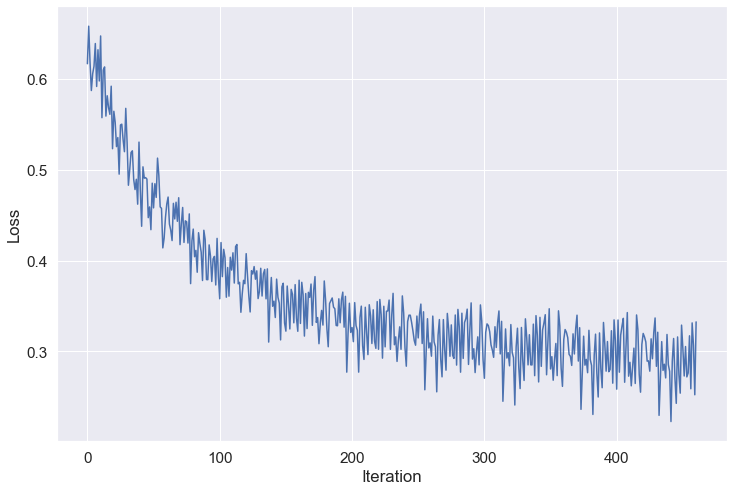

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

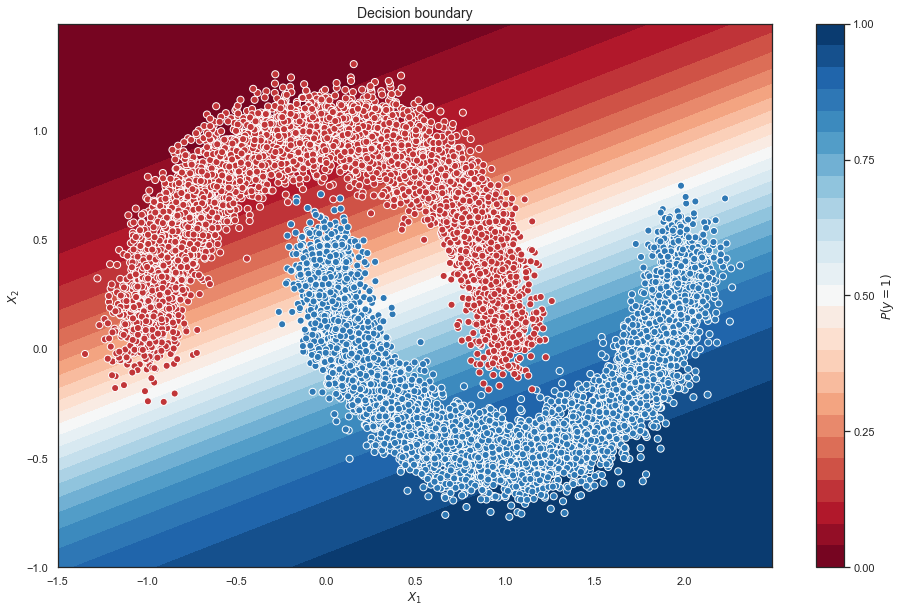

In [14]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [15]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = linear_regression(X_batch)
        outp = outp.view(-1)
        loss = loss_function(outp, y_batch)
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [16]:
from sklearn.metrics import accuracy_score

y_pred = predict(val_dataloader, linear_regression)
acc = accuracy_score(y_val, y_pred[0:2500])
print(acc)

0.5024


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.5024

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [2]:
#Установим недостающий компонент
!pip install torchsummary

In [3]:
#импортирую необходимых утилит, а то создатели про них забыли
import os
import torchvision

from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchsummary import summary

In [52]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128
num_workers = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                               num_workers=num_workers)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                               num_workers=num_workers)

Выведем первую картинку:

In [5]:
train_dataloader.dataset.train_data[0].numpy()

C:\Users\user\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Посмотрим, как она выглядит:

In [8]:
#преобразуем тензор в np.array
numpy_img = train_dataloader.dataset.train_data[0].numpy()

In [9]:
numpy_img.shape

(28, 28)

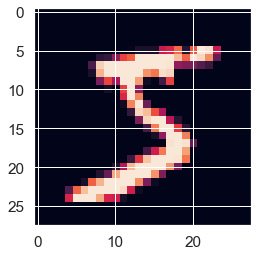

In [11]:
plt.imshow(numpy_img)

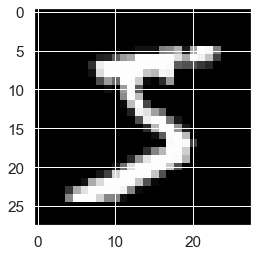

In [12]:
plt.imshow(numpy_img, cmap='gray')

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [5]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [21]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation,
    nn.Linear(128,128),
    activation,
    nn.Linear(128, 10)
)

In [22]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [9]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                #перевожу модель в режим train
                model.train()
                #обнуляю градиенты модели
                optimizer.zero_grad()
                outp = model(x_batch)
                #считаю лосс логистической регрессии
                loss = criterion(outp, y_batch)     
            else:
                #переводим модель в режим eval
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum().item()
            all = y_batch.size(0)
            epoch_correct += correct
            epoch_all += all
            
            if k == "train":
                loss = criterion(outp, y_batch)
                #Считаю градиенты
                loss.backward()
                #задаю шаг градиентного спуска
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8879666666666667
Loader: valid. Accuracy: 0.938
Epoch: 2
Loader: train. Accuracy: 0.9482333333333334
Loader: valid. Accuracy: 0.9592
Epoch: 3
Loader: train. Accuracy: 0.9638666666666666
Loader: valid. Accuracy: 0.9668
Epoch: 4
Loader: train. Accuracy: 0.9708666666666667
Loader: valid. Accuracy: 0.9657
Epoch: 5
Loader: train. Accuracy: 0.9762333333333333
Loader: valid. Accuracy: 0.9668
Epoch: 6
Loader: train. Accuracy: 0.979
Loader: valid. Accuracy: 0.9732
Epoch: 7
Loader: train. Accuracy: 0.9814666666666667
Loader: valid. Accuracy: 0.9766
Epoch: 8
Loader: train. Accuracy: 0.9833666666666666
Loader: valid. Accuracy: 0.9728
Epoch: 9
Loader: train. Accuracy: 0.9861166666666666
Loader: valid. Accuracy: 0.9785
Epoch: 10
Loader: train. Accuracy: 0.9879166666666667
Loader: valid. Accuracy: 0.9761


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [10]:
elu_accuracy = accuracy["valid"]

In [11]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation,
    nn.Linear(128,128),
    activation,
    nn.Linear(128, 10)
)
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}

def test_activation_function(activation):
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    #перевожу модель в режим train
                    model.train()
                    #обнуляю градиенты модели
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    #считаю лосс логистической регрессии
                    loss = criterion(outp, y_batch)  
                else:
                    #переводим модель в режим eval
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)
                correct =  (preds == y_batch).sum().item() #количество корректных предсказаний меток классов в батче
                all = y_batch.size(0)     #общее количество объектов в батче
                epoch_correct += correct
                epoch_all += all

                if k == "train":
                    loss = criterion(outp, y_batch)
                    #Считаю градиенты
                    loss.backward()
                    #задаю шаг градиентного спуска
                    optimizer.step()
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']

In [14]:
#Перед активацией необходимо заново инициализировать модель
plain_accuracy = test_activation_function(Identical())

Epoch: 1
Loader: train. Accuracy: 0.8914333333333333
Loader: valid. Accuracy: 0.9428
Epoch: 2
Loader: train. Accuracy: 0.9506166666666667
Loader: valid. Accuracy: 0.9616
Epoch: 3
Loader: train. Accuracy: 0.96395
Loader: valid. Accuracy: 0.968
Epoch: 4
Loader: train. Accuracy: 0.9712666666666666
Loader: valid. Accuracy: 0.9715
Epoch: 5
Loader: train. Accuracy: 0.9755666666666667
Loader: valid. Accuracy: 0.9683
Epoch: 6
Loader: train. Accuracy: 0.97925
Loader: valid. Accuracy: 0.9743
Epoch: 7
Loader: train. Accuracy: 0.9819666666666667
Loader: valid. Accuracy: 0.9777
Epoch: 8
Loader: train. Accuracy: 0.98435
Loader: valid. Accuracy: 0.969
Epoch: 9
Loader: train. Accuracy: 0.9856833333333334
Loader: valid. Accuracy: 0.9709
Epoch: 10
Loader: train. Accuracy: 0.9884
Loader: valid. Accuracy: 0.9771


In [17]:
#Перед активацией необходимо заново инициализировать модель
relu_accuracy = test_activation_function(nn.ReLU())

Epoch: 1
Loader: train. Accuracy: 0.8873
Loader: valid. Accuracy: 0.9357
Epoch: 2
Loader: train. Accuracy: 0.9474666666666667
Loader: valid. Accuracy: 0.9552
Epoch: 3
Loader: train. Accuracy: 0.9625666666666667
Loader: valid. Accuracy: 0.9626
Epoch: 4
Loader: train. Accuracy: 0.9704
Loader: valid. Accuracy: 0.9655
Epoch: 5
Loader: train. Accuracy: 0.9756666666666667
Loader: valid. Accuracy: 0.972
Epoch: 6
Loader: train. Accuracy: 0.9786
Loader: valid. Accuracy: 0.9708
Epoch: 7
Loader: train. Accuracy: 0.9814166666666667
Loader: valid. Accuracy: 0.9727
Epoch: 8
Loader: train. Accuracy: 0.9836
Loader: valid. Accuracy: 0.9717
Epoch: 9
Loader: train. Accuracy: 0.9849
Loader: valid. Accuracy: 0.9751
Epoch: 10
Loader: train. Accuracy: 0.9864166666666667
Loader: valid. Accuracy: 0.9752


In [20]:
#Перед активацией необходимо заново инициализировать модель
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

Epoch: 1
Loader: train. Accuracy: 0.8865166666666666
Loader: valid. Accuracy: 0.9384
Epoch: 2
Loader: train. Accuracy: 0.94795
Loader: valid. Accuracy: 0.9585
Epoch: 3
Loader: train. Accuracy: 0.9630333333333333
Loader: valid. Accuracy: 0.9604
Epoch: 4
Loader: train. Accuracy: 0.9707
Loader: valid. Accuracy: 0.9695
Epoch: 5
Loader: train. Accuracy: 0.97555
Loader: valid. Accuracy: 0.9693
Epoch: 6
Loader: train. Accuracy: 0.9789666666666667
Loader: valid. Accuracy: 0.9734
Epoch: 7
Loader: train. Accuracy: 0.9815166666666667
Loader: valid. Accuracy: 0.9723
Epoch: 8
Loader: train. Accuracy: 0.9828
Loader: valid. Accuracy: 0.9774
Epoch: 9
Loader: train. Accuracy: 0.9851833333333333
Loader: valid. Accuracy: 0.9767
Epoch: 10
Loader: train. Accuracy: 0.9868666666666667
Loader: valid. Accuracy: 0.977


In [23]:
#Перед активацией необходимо заново инициализировать модель
elu_accuracy = test_activation_function(nn.ELU())

Epoch: 1
Loader: train. Accuracy: 0.8847
Loader: valid. Accuracy: 0.9408
Epoch: 2
Loader: train. Accuracy: 0.9483666666666667
Loader: valid. Accuracy: 0.957
Epoch: 3
Loader: train. Accuracy: 0.9632333333333334
Loader: valid. Accuracy: 0.96
Epoch: 4
Loader: train. Accuracy: 0.9714666666666667
Loader: valid. Accuracy: 0.9708
Epoch: 5
Loader: train. Accuracy: 0.9759166666666667
Loader: valid. Accuracy: 0.9725
Epoch: 6
Loader: train. Accuracy: 0.9788833333333333
Loader: valid. Accuracy: 0.976
Epoch: 7
Loader: train. Accuracy: 0.98205
Loader: valid. Accuracy: 0.9714
Epoch: 8
Loader: train. Accuracy: 0.98355
Loader: valid. Accuracy: 0.9736
Epoch: 9
Loader: train. Accuracy: 0.9854666666666667
Loader: valid. Accuracy: 0.9763
Epoch: 10
Loader: train. Accuracy: 0.9864666666666667
Loader: valid. Accuracy: 0.9759


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

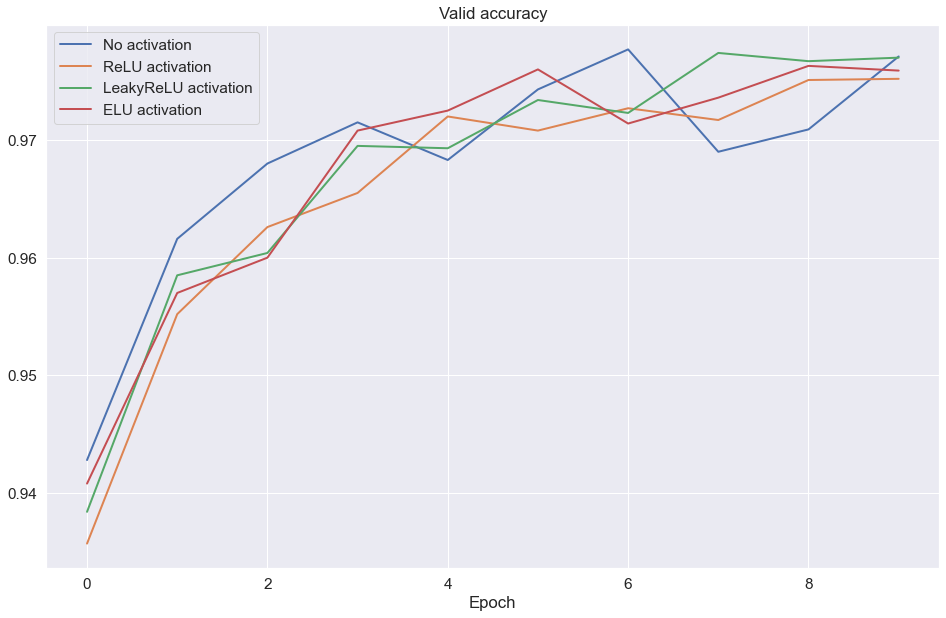

In [24]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

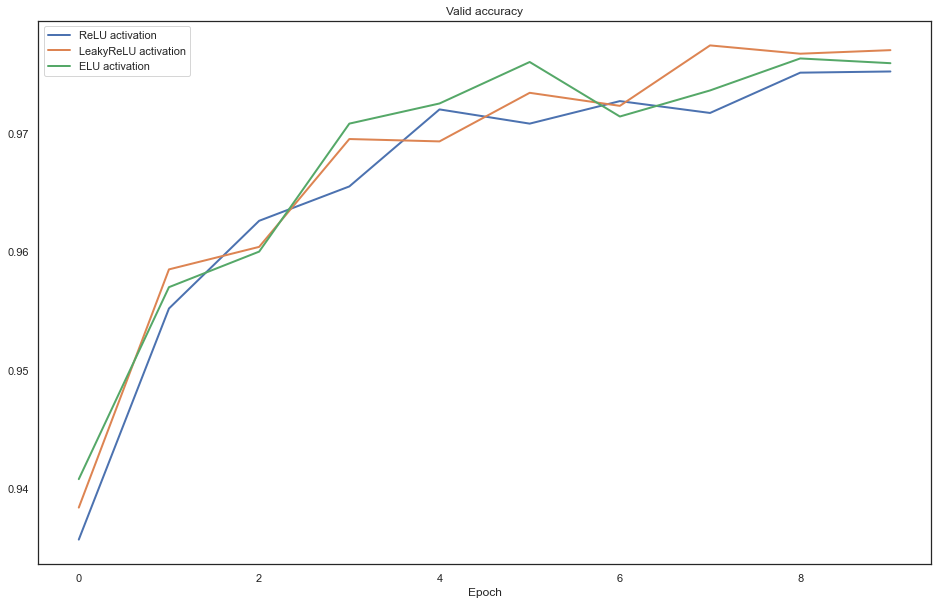

In [70]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU activation

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [7]:
!pip install opencv-python

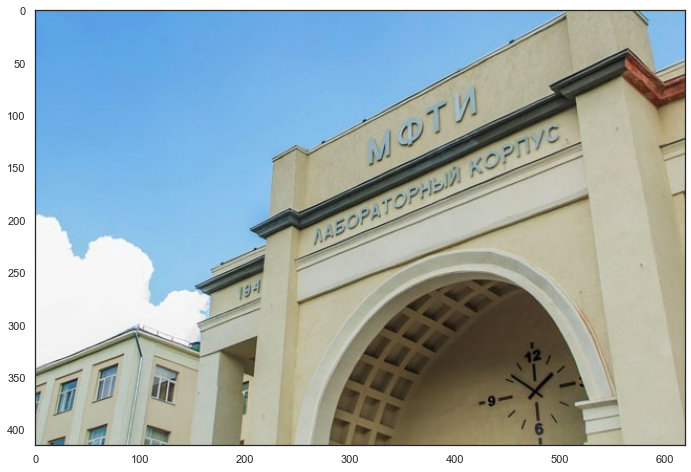

In [26]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

Вариант А

In [12]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


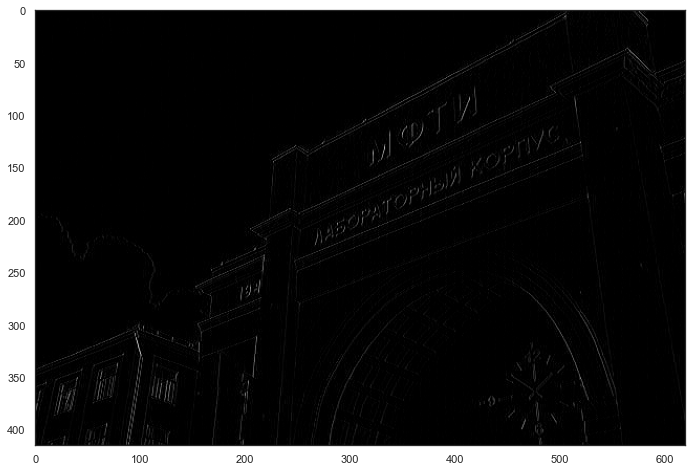

In [13]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

In [ ]:
Вариант Б

In [15]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


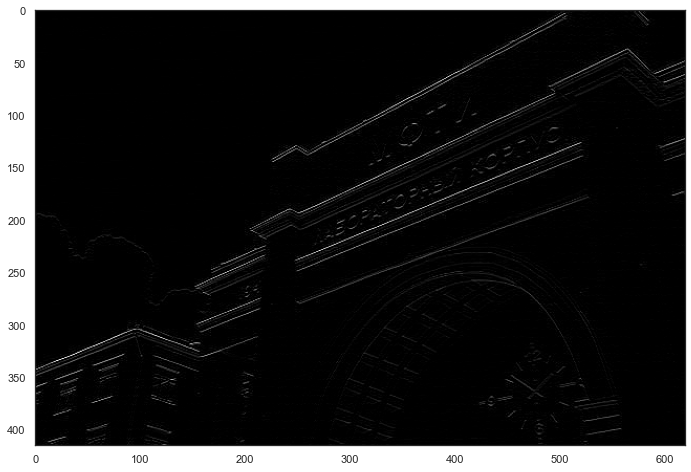

In [16]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

In [ ]:
Вариант В

In [17]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


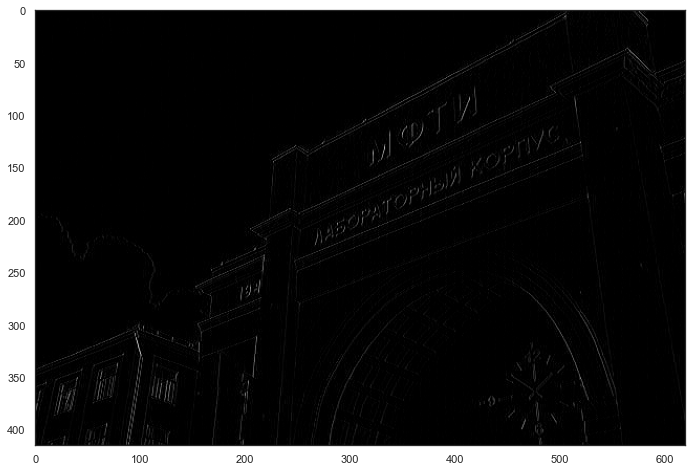

In [18]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

In [ ]:
Вариант Г

In [19]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


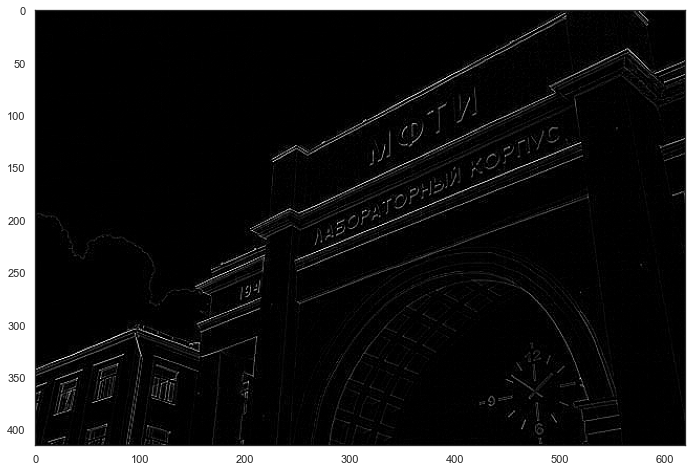

In [20]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

In [ ]:
Вариант Д

In [21]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


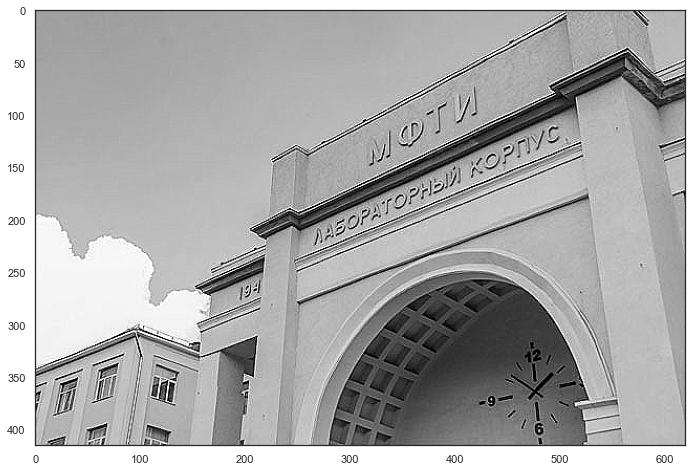

In [22]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

In [ ]:
Вариант Е

In [23]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  

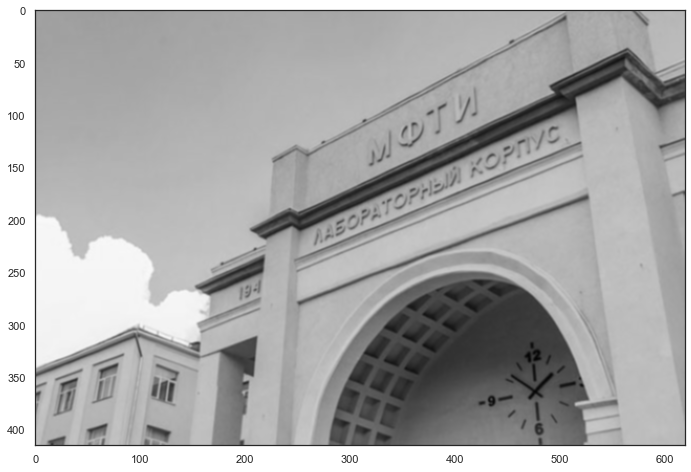

In [24]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

1 - Е

2 - Д

3 - А

4 - В

5 - Б

6 - Г


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [60]:
#Чтобы не бегать по ноутбуку
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128
num_workers = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                               num_workers=num_workers)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                               num_workers=num_workers)

In [61]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [62]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)  #Свёртки 3x3 (1 карта на входе, 6 на выходе)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  #MaxPooling-а 2x2;
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)  #Свёртки 3x3 (6 карт на входе, 16 на выходе)
        self.fc1 = nn.Flatten()  #Уплощение (nn.Flatten)
        self.fc2 = nn.Linear(5 * 5 * 16, 120)  #Полносвязный слой со 120 нейронами
        self.fc3 = nn.Linear(120, 84)  #Полносвязный слой с 84 нейронами
        self.fc4 = nn.Linear(84, 10)  #Выходной слой из 10 нейронов

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

"view" и "reshape" в некотором смысле похожи, но не являются одним и тем же.

"View" в PyTorch - это метод, который создает новый тензор с теми же данными, что и исходный тензор, но с другой формой. Это означает, что изменение формы с помощью "view" не изменяет фактических данных в тензоре. Это может быть полезно для изменения формы тензора, не требуя копирования данных, что может ускорить выполнение операций.

"Reshape" - это функция, которая изменяет форму тензора, копируя его данные в новый тензор с новой формой. В отличие от "view", "reshape" создает новый тензор с новыми данными, поэтому может потребоваться больше времени на выполнение.

x = x.reshape()

x.view()

Я пока увидел разницу только в этом, что требуется операция присвоения для решейпа

In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [64]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [67]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

#итерируемся по датасету max_epochs раз
for epoch in range(max_epochs):
    #проход сначала по train, затем по valid
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            #отправка на GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                #перевожу модель в режим train
                model.train()
                #обнуляю градиенты модели
                optimizer.zero_grad()
                outp = model(x_batch)
                #считаю лосс логистической регрессии
                loss = criterion(outp, y_batch)     
            else:
                #переводим модель в режим eval
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum().item()
            all = y_batch.size(0)
            epoch_correct += correct
            epoch_all += all
            
            if k == "train":
                loss = criterion(outp, y_batch)
                #Считаю градиенты
                loss.backward()
                #задаю шаг градиентного спуска
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8791333333333333
Loader: valid. Accuracy: 0.9629
Epoch: 2
Loader: train. Accuracy: 0.9689333333333333
Loader: valid. Accuracy: 0.9793
Epoch: 3
Loader: train. Accuracy: 0.9778166666666667
Loader: valid. Accuracy: 0.9809
Epoch: 4
Loader: train. Accuracy: 0.98195
Loader: valid. Accuracy: 0.9847
Epoch: 5
Loader: train. Accuracy: 0.9852833333333333
Loader: valid. Accuracy: 0.9811
Epoch: 6
Loader: train. Accuracy: 0.9867166666666667
Loader: valid. Accuracy: 0.9883
Epoch: 7
Loader: train. Accuracy: 0.9889166666666667
Loader: valid. Accuracy: 0.9869
Epoch: 8
Loader: train. Accuracy: 0.9903333333333333
Loader: valid. Accuracy: 0.9856
Epoch: 9
Loader: train. Accuracy: 0.9913166666666666
Loader: valid. Accuracy: 0.9873
Epoch: 10
Loader: train. Accuracy: 0.9926333333333334
Loader: valid. Accuracy: 0.987


In [69]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

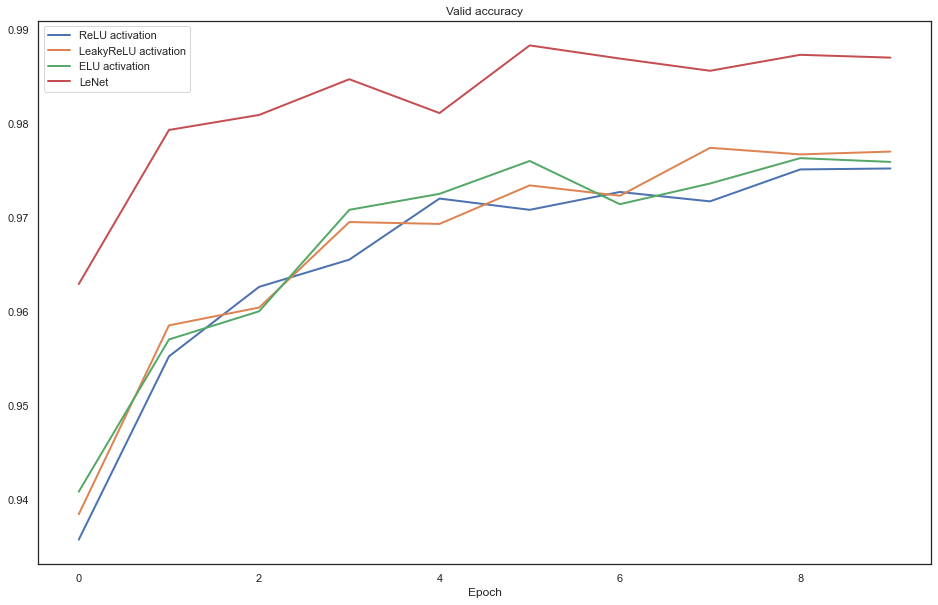

In [71]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [74]:
"accuracy: {:0.2f}".format(lenet_accuracy[-1])

'accuracy: 0.99'